In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
admin_agg='ADM3_PCODE'
city_id='UC_NM_MN'
demographics=[
'AGE', 
'WEALTH_INDEX',
'POP_DENS',
]

In [3]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

In [4]:
print('Import parquet files')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import parquet files
Done in 7 sec


In [5]:
print('Import admin data')
start = timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
print("Done in", round(timer()-start), "sec")  

Import admin data
Done in 69 sec


In [6]:
print('Turn primary home into GDF')
primary_home=get_coords(primary_home)
primary_home=gpd.GeoDataFrame(primary_home,geometry=gpd.points_from_xy(primary_home.longitude,primary_home.latitude))
primary_home.crs='epsg:4326'
print("Done in", round(timer()-start), "sec")  

Turn primary home into GDF
Done in 70 sec


In [8]:
print('Merge data')
start = timer()

geocoded_home=gpd.sjoin(admin[[admin_id,'geometry']],primary_home[['cuebiq_id','geometry']],op='intersects')
geocoded_home=admin.merge(geocoded_home.groupby(admin_id)['cuebiq_id'].count().rename('n_users'),on=admin_id,how='left')

geocoded_home=geocoded_home.dissolve(
by=admin_agg,aggfunc={
city_id:'first',
'POP':'sum',
'AREA_KM2':'sum',
'WEALTH_INDEX':'mean',
'AGE':'median',
'n_users':'sum'})

geocoded_home['POP_DENS']=geocoded_home.total_population.divide(geocoded_home.AREA_KM2)
geocoded_home['PENETRATION']=geocoded_home.n_users.divide(geocoded_home.POP)*100
top_cities=admin.UC_NM_MN.value_counts().index[:5]

print("Done in", round(timer()-start), "sec")

Merge data
Done in 432 sec


# Penetration rates

/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


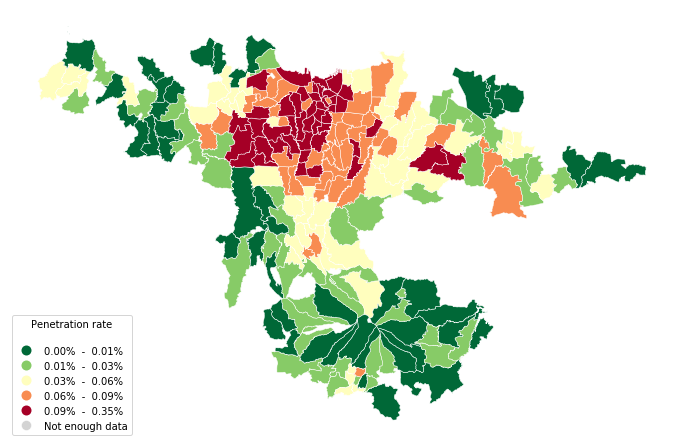

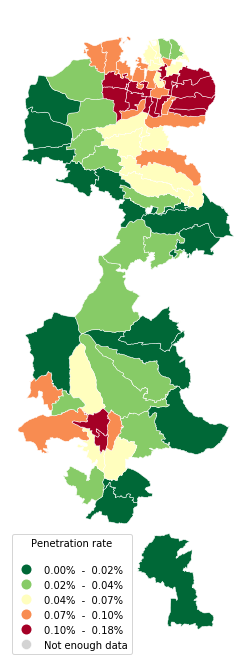

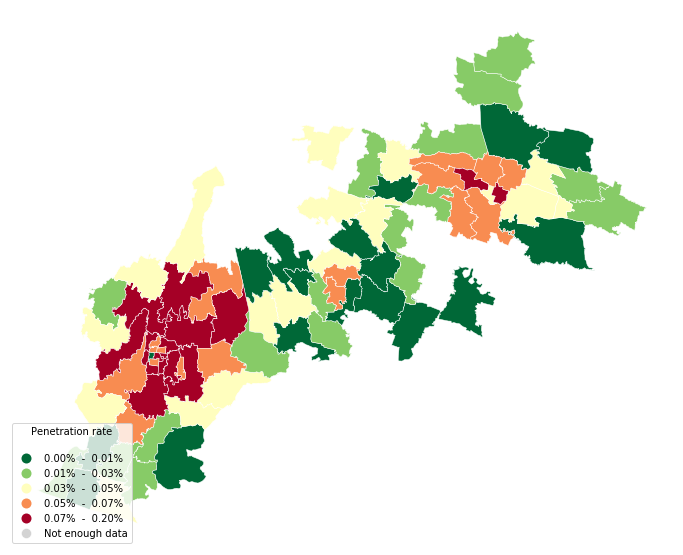

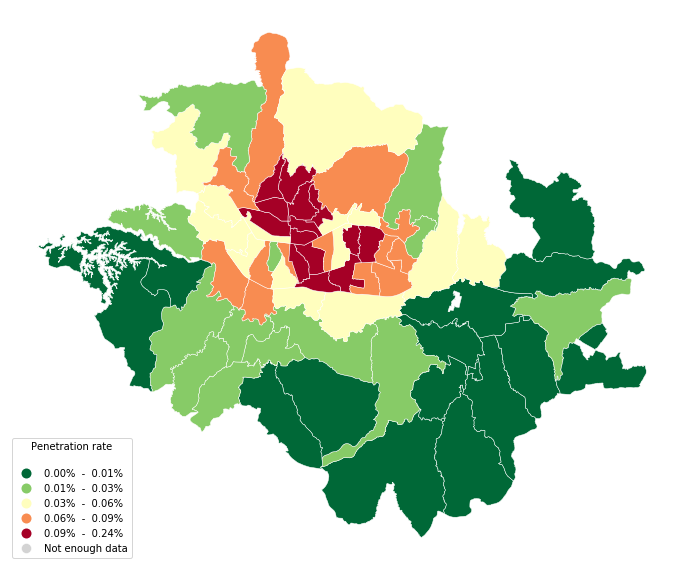

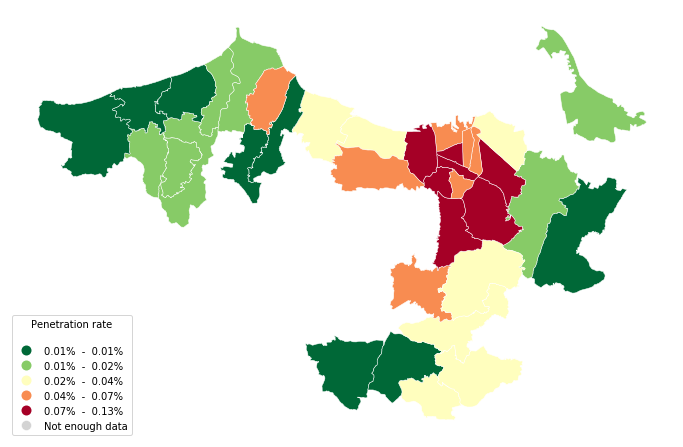

In [13]:
for city_name in top_cities:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    plot = geocoded_home[geocoded_home.UC_NM_MN==city_name].plot(
    ax=ax,
    column='PENETRATION', 
    edgecolor='white', 
    linewidth=0.5,
    legend=True, 
    cmap='RdYlGn_r', 
    scheme='quantiles',
    missing_kwds={"color": "lightgrey","hatch": "///","label": "Not enough data",},
    legend_kwds={'loc': 'lower left','title':'Penetration rate\n'})
    ax.axis('off')
    leg = plot.get_legend()
    for lbl in leg.get_texts()[:-1]:
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.2f}%  -  {float(upper):,.2f}%'
        lbl.set_text(new_text)
    plt.savefig(os.path.join(path_to_data,'../fig/map-'+city_name+'.pdf'), bbox_inches='tight')

# Penetration bias

In [22]:
def penetration_bias(df,col,name,n_bins):
    fig,ax=plt.subplots(figsize=(8,6))
    data=df.groupby(pd.qcut(df[col],n_bins,range(1,n_bins+1)))['PENETRATION'].agg(['mean','sem']).dropna()
    plt.errorbar(data.index, 'mean', data=data, linewidth=1, color='k')
    ax.fill_between(data.index,data['mean']-2*data['sem'],data['mean']+2*data['sem'],alpha=0.25,color='k')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_ylabel('Share of users (% of total pop.)',fontweight='bold')
    ax.set_xlabel('Decile of '+name.lower(),fontweight='bold')
    ax.locator_params(axis='both',nbins=10)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals/100])
    plt.savefig(os.path.join(path_to_data+'/../fig',country,name.replace(' ','-')+'-penetration-bias.pdf'),bbox_inches='tight')

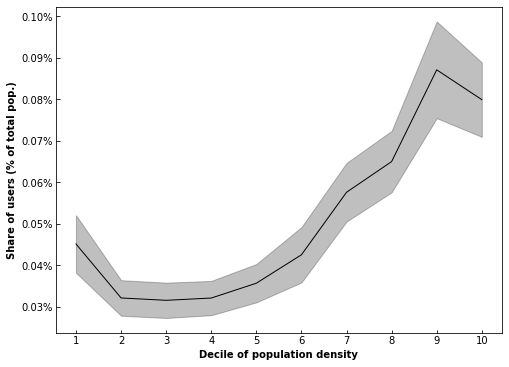

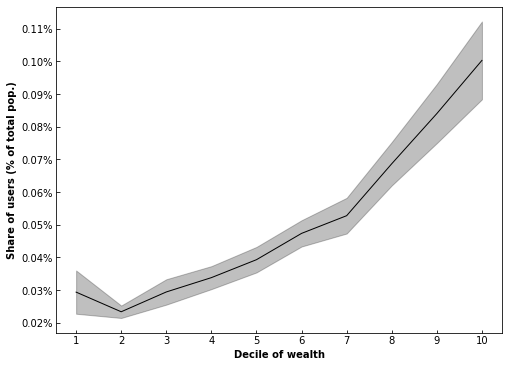

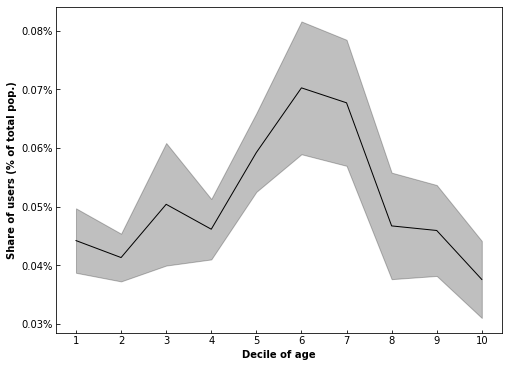

In [23]:
df=geocoded_home[geocoded_home.n_users>=10].replace([np.inf, -np.inf], np.nan).copy()
for (col,name) in zip(['POP_DENS','WEALTH_INDEX','AGE'],['POPULATION DENSITY','WEALTH','AGE']):
    penetration_bias(df,col,name,n_bins=10)